In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
project_path =  '/content/drive/My Drive/Colab Data'
os.chdir(project_path)
os.listdir()

## Loading the dataset

In [ ]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

In [ ]:
df = pd.read_csv('indonesian-sarcasm-balanced-shuffled-v2.csv')
df.headline=df.headline.astype(str)
df.head()

,is_sarcastic,headline
0,0,entah kenapa tapi kebanyakan anak cowok memang...
1,1,"kan ga melengkung, karena bumi itu flat"
2,1,"uh, you don't need that's the core doctrine of..."
3,1,"lelenya atheis, haram"
4,0,"di sini ga bisa sarkasme tanpa "" s"""


In [ ]:
df.shape

(11378, 2)

The dataset used here contains 11378 rows of indonesian comments with two features: the comments and an true/false indicator for sarcasm.

## Exploring the dataset

In [ ]:
df_sarcastic = df[df['is_sarcastic']==1]
df_sarcastic.shape

(5654, 2)

In [ ]:
df_not_sarcastic = df[df['is_sarcastic']==0]
df_not_sarcastic.shape

(5724, 2)

Here we can see the number of sarcastic and non-sarcastic comments in the dataset.

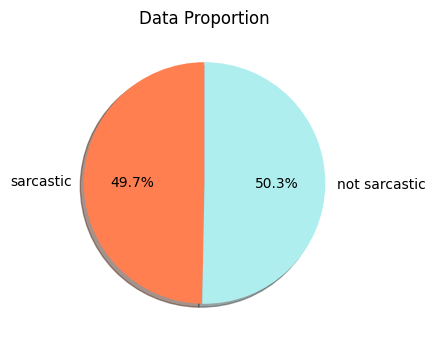

In [ ]:
pie_slices = []
pie_slices.append(len(df_sarcastic)/len(df))
pie_slices.append(len(df_not_sarcastic)/len(df))
labels = ['sarcastic','not sarcastic']
plt.figure(dpi=100)
plt.pie(pie_slices, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, colors=['coral','paleturquoise'])
plt.title('Data Proportion')
plt.show()

The pie chart indicates that the dataset is a balanced one and consists of **49.7% sarcastic** comment and **50.3% non-sarcastic** comment.

### Tokenizing

In this part we are tokenizing the dataset as a preparation for the model training.

In [ ]:
import numpy as np
from gensim.models import Word2Vec
from nltk import word_tokenize
from nltk.tokenize import TweetTokenizer
import pandas as pd

In [ ]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
data = df['headline'].map(word_tokenize)

In [ ]:
target = df['is_sarcastic']

In [ ]:
data[:5]

0    [entah, kenapa, tapi, kebanyakan, anak, cowok,...
1    [kan, ga, melengkung, ,, karena, bumi, itu, flat]
2    [uh, ,, you, do, n't, need, that, 's, the, cor...
3                          [lelenya, atheis, ,, haram]
4     [di, sini, ga, bisa, sarkasme, tanpa, ``, s, '']
Name: headline, dtype: object

These are the first 5 rows of the already tokenized comments.

In the next section we can see the number of tokens and unique tokens in the dataset.

In [ ]:
import pandas as pd
total_tokens = [381224, 93873, 287351]
unique_tokens = [24883, 10673, 20467]
columns = ["All Comments","Sarcastic","Non-Sarcastic"]
token_data = pd.DataFrame([total_tokens, unique_tokens],index=["Total","Unique"],columns=columns)
token_data

,All Comments,Sarcastic,Non-Sarcastic
Total,381224,93873,287351
Unique,24883,10673,20467


This table shows the result obtained in this section; a count of the total tokens and unique tokens for all comments, and a separate count for only the sarcastic and non-sarcastic comments.

In [ ]:
total_vocabulary = set(word for headline in data for word in headline)

In [ ]:
len(total_vocabulary)
print("There are {} unique tokens in our dataset.".format(len(total_vocabulary)))

There are 24883 unique tokens in our dataset.


In [ ]:
all_words = list(word for headline in data for word in headline)

In [ ]:
len(all_words)
print("There are {} total tokens in our dataset.".format(len(all_words)))

There are 381224 total tokens in our dataset.


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk import FreqDist
from nltk.corpus import stopwords
import string
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', "'s", "n't"]

all_words_stopped = [word for word in all_words if word not in stopwords_list]

#### Sarcastic words

In [ ]:
sarc_data = df_sarcastic['headline'].map(word_tokenize)

In [ ]:
total_sarc_vocabulary = set(word for headline in sarc_data for word in headline)

In [ ]:
len(total_sarc_vocabulary)
print("There are {} unique tokens from sarcastic articles in our dataset.".format(len(total_sarc_vocabulary)))

There are 10673 unique tokens from sarcastic articles in our dataset.


In [ ]:
all_sarc_words = list(word for headline in sarc_data for word in headline)

In [ ]:
len(all_sarc_words)
print("There are {} total tokens in our sarcastic articles.".format(len(all_sarc_words)))

There are 93873 total tokens in our sarcastic articles.


#### Non-sarcastic words

In [ ]:
nonsarc_data = df_not_sarcastic['headline'].apply(str).map(word_tokenize)

In [ ]:
total_nonsarc_vocabulary = set(word for headline in nonsarc_data for word in headline)

In [ ]:
len(total_nonsarc_vocabulary)
print("There are {} unique tokens from non-sarcastic articles in our dataset.".format(len(total_nonsarc_vocabulary)))

There are 20467 unique tokens from non-sarcastic articles in our dataset.


In [ ]:
all_nonsarc_words = list(word for headline in nonsarc_data for word in headline)

In [ ]:
len(all_nonsarc_words)
print("There are {} total tokens in our non-sarcastic articles.".format(len(all_nonsarc_words)))

There are 287351 total tokens in our non-sarcastic articles.


## Convolutional neural network

### Training the model

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D, GRU, GlobalMaxPool1D, Conv1D, MaxPool1D, Flatten, Activation
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

import tensorflow as tf
from tensorflow.keras import Sequential
import time
from keras.callbacks import TensorBoard

In [ ]:
from sklearn.preprocessing import LabelEncoder
Y = df.is_sarcastic
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)
X = df.headline

In [ ]:
# CNN
embedding_size = 128
input_ = Input(shape=(150,))
x = Embedding(20000, 128, input_length=150)(input_)
x = Dropout(0.9)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = Activation('relu')(x)
x = MaxPool1D(2)(x)
x = Dropout(0.9)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = Activation('relu')(x)
x = MaxPool1D(2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_, outputs=x)

# LSTM
# embedding_size = 128
# input_ = Input(shape=(150,))
# x = Embedding(30000, embedding_size)(input_)
# x = Bidirectional(LSTM(256, return_sequences=True))(x)
# x = GlobalMaxPool1D()(x)
# x = Dropout(0.5)(x)
# x = Dense(50, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(1, activation='sigmoid')(x)

# model = Model(inputs=input_, outputs=x)

# CNN-LSTM
# embedding_size = 128
# input_ = Input(shape=(150,))
# x = Embedding(20000, 50, input_length=150)(input_)
# x = Dropout(0.9)(x)
# x = Conv1D(250, 3, padding = "valid", activation = "relu", strides = 1)(x)
# x = MaxPool1D(4)(x)
# x = Dropout(0.8)(x)
# x = LSTM(256)(x)
# x = Dense(256)(x)
# x = Dropout(0.5)(x)
# x = Activation("relu")(x)
# x = Dense(1) (x)
# x = Activation("sigmoid")(x)

# model = Model(inputs=input_, outputs=x)

In [ ]:
# This part splits 10% of the dataset as the test data.
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

In [ ]:
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(X_train))
list_tokenized_headlines = tokenizer.texts_to_sequences(X_train)
X_t = sequence.pad_sequences(list_tokenized_headlines, maxlen=150)

In [ ]:
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 128)          2560000   
_________________________________________________________________
dropout (Dropout)            (None, 150, 128)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 148, 64)           24640     
_________________________________________________________________
activation (Activation)      (None, 148, 64)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 74, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 74, 64)           

In [ ]:
# Callback for early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
history = model.fit(X_t, Y_train, epochs=50, batch_size=1000, validation_split=0.1, shuffle=True) #, callbacks=[early_stopping])

Epoch 1/50
10/10 [==============================] - 2s 223ms/step - loss: 0.7354 - accuracy: 0.4982 - precision: 0.4948 - recall: 0.6004 - val_loss: 0.6933 - val_accuracy: 0.5234 - val_precision: 0.5138 - val_recall: 0.8711
Epoch 2/50
10/10 [==============================] - 1s 110ms/step - loss: 0.6941 - accuracy: 0.5033 - precision: 0.4992 - recall: 0.7204 - val_loss: 0.6931 - val_accuracy: 0.5889 - val_precision: 0.5619 - val_recall: 0.8066
Epoch 3/50
10/10 [==============================] - 1s 109ms/step - loss: 0.6921 - accuracy: 0.5049 - precision: 0.5019 - recall: 0.1136 - val_loss: 0.6929 - val_accuracy: 0.5303 - val_precision: 0.6131 - val_recall: 0.1641
Epoch 4/50
10/10 [==============================] - 1s 109ms/step - loss: 0.6906 - accuracy: 0.5046 - precision: 0.6000 - recall: 6.5689e-04 - val_loss: 0.6928 - val_accuracy: 0.5752 - val_precision: 0.5893 - val_recall: 0.4961
Epoch 5/50
10/10 [==============================] - 1s 108ms/step - loss: 0.6888 - accuracy: 0.5044 

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


### Training result graph

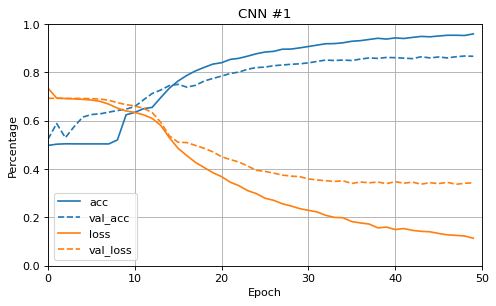

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize = (7, 4), dpi=80)
plt.ylim([0, 1])
plt.xlim([0, 50])
plt.grid(True)
plt.plot(history.history['accuracy'], color=colors[0])
plt.plot(history.history['val_accuracy'], color=colors[0], linestyle="--")
plt.plot(history.history['loss'], color=colors[1])
plt.plot(history.history['val_loss'], color=colors[1], linestyle="--")
plt.title('CNN #1')
plt.ylabel('Percentage')
plt.xlabel('Epoch')
plt.legend(['acc', 'val_acc', 'loss', 'val_loss'], loc='best')
plt.show()

### Applying the model on the test data

In [ ]:
list_tokenized_headlines = tokenizer.texts_to_sequences(X_test)
X_tt = sequence.pad_sequences(list_tokenized_headlines, maxlen=150)
accr = model.evaluate(X_tt,Y_test)
# print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

36/36 [==============================] - 0s 6ms/step - loss: 0.2809 - accuracy: 0.8998 - precision: 0.8736 - recall: 0.9374


#### Result

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Test Data Metrics
print('Loss: {:0.3f}'.format(accr[0]))
print('Accuracy: {:0.3f}'.format(accr[1]))
print('Precision: {:0.3f}'.format(accr[2]))
print('Recall: {:0.3f}'.format(accr[3]))
f1 = 2 * (accr[2] * accr[3]) / (accr[2] + accr[3])
print('F1 Score: {:0.3f}'.format(f1))

Loss: 0.281
Accuracy: 0.900
Precision: 0.874
Recall: 0.937
F1 Score: 0.904


Text(0.5, 1.0, 'Confusion Matrix for Convolutional Neural Network')

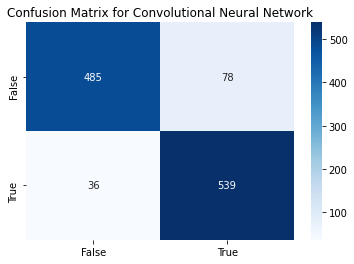

In [ ]:
#Confusion Matrix
y_pred = (model.predict(X_tt) > 0.5).astype("int32") # (model.predict(x) > 0.5).astype("int32"), if your model does binary classification (e.g. if it uses a sigmoid last-layer activation).

# mat = confusion_matrix(Y_test, y_pred)
# plot_confusion_matrix(conf_mat=mat)

from sklearn import metrics
mat = metrics.confusion_matrix(Y_test, y_pred)
mat = pd.DataFrame(mat, index = ["False", "True"], columns=["False", "True"])
sns.heatmap(mat, annot = True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix for Convolutional Neural Network")